<a href="https://colab.research.google.com/github/MartinPdeS/SuPyMode/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing SuPyMode and depedencies

In [1]:
!python -m pip install SuPyMode --no-cache-dir --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 261.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 285.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 300.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 269.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 kB 303.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.6/145.6 MB 228.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 184.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.8/306.8 kB 320.4 MB/s eta 0:00:00


## Quick fix: restart the session after the !pip command above.
Go on Runtime/Restart Session

## Importing the package

In [2]:
from SuPyMode.workflow import Workflow, fiber_loader, Boundaries, BoundaryValue, DomainAlignment, Profile, StructureType

from PyOptik import MaterialBank

In [4]:
wavelength = 1550e-9

# %%
# Generating the fiber structure
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Here we define the cladding and fiber structure to model the problem
clad_structure = Profile()

clad_structure.add_structure(
    structure_type=StructureType.CIRCULAR,
    number_of_fibers=4,
    fusion_degree=0.4,
    fiber_radius=62.5e-6,
)

clad_structure.refractive_index = MaterialBank.fused_silica.compute_refractive_index(wavelength)  # Refractive index of silica at the specified wavelength


fiber_list = [
    fiber_loader.load_fiber('DCF1300S_33', clad_refractive_index=clad_structure.refractive_index, position=clad_structure.cores[0]),
    fiber_loader.load_fiber('DCF1300S_26', clad_refractive_index=clad_structure.refractive_index, position=clad_structure.cores[1]),
    fiber_loader.load_fiber('DCF1300S_42', clad_refractive_index=clad_structure.refractive_index, position=clad_structure.cores[2]),
    fiber_loader.load_fiber('DCF1300S_33', clad_refractive_index=clad_structure.refractive_index, position=clad_structure.cores[3]),
]

In [12]:
boundaries = [
    Boundaries(right=BoundaryValue.SYMMETRIC, top=BoundaryValue.SYMMETRIC),
    Boundaries(right=BoundaryValue.SYMMETRIC, top=BoundaryValue.ANTI_SYMMETRIC),
]

workflow = Workflow(
    fiber_list=fiber_list,          # List of fiber to be added in the mesh, the order matters.
    clad_structure=clad_structure,  # Cladding structure, if None provided then no cladding is set.
    wavelength=wavelength,          # Wavelength used for the mode computation.
    resolution=80,                  # Number of point in the x and y axis [is divided by half if symmetric or anti-symmetric boundaries].
    x_bounds=DomainAlignment.LEFT,  # Mesh x-boundary structure.
    y_bounds=DomainAlignment.BOTTOM,# Mesh y-boundary structure.
    boundaries=boundaries,          # Set of symmetries to be evaluated, each symmetry add a round of simulation
    n_sorted_mode=3,                # Total computed and sorted mode.
    n_added_mode=5,                 # Additional computed mode that are not considered later except for field comparison [the higher the better but the slower].
    debug_mode=0,                   # Print the iteration step for the solver plus some other important steps.
    auto_label=True,                # Auto labeling the mode. Label are not always correct and should be verified afterwards.
    itr_final=0.1,                  # Final value of inverse taper ratio to simulate
    index_scrambling=1e-4           # Scrambling of refractive index value in order to lift mode degeneracy [useful for some analysis]
)

workflow.initialize_geometry()

workflow.run_solver()

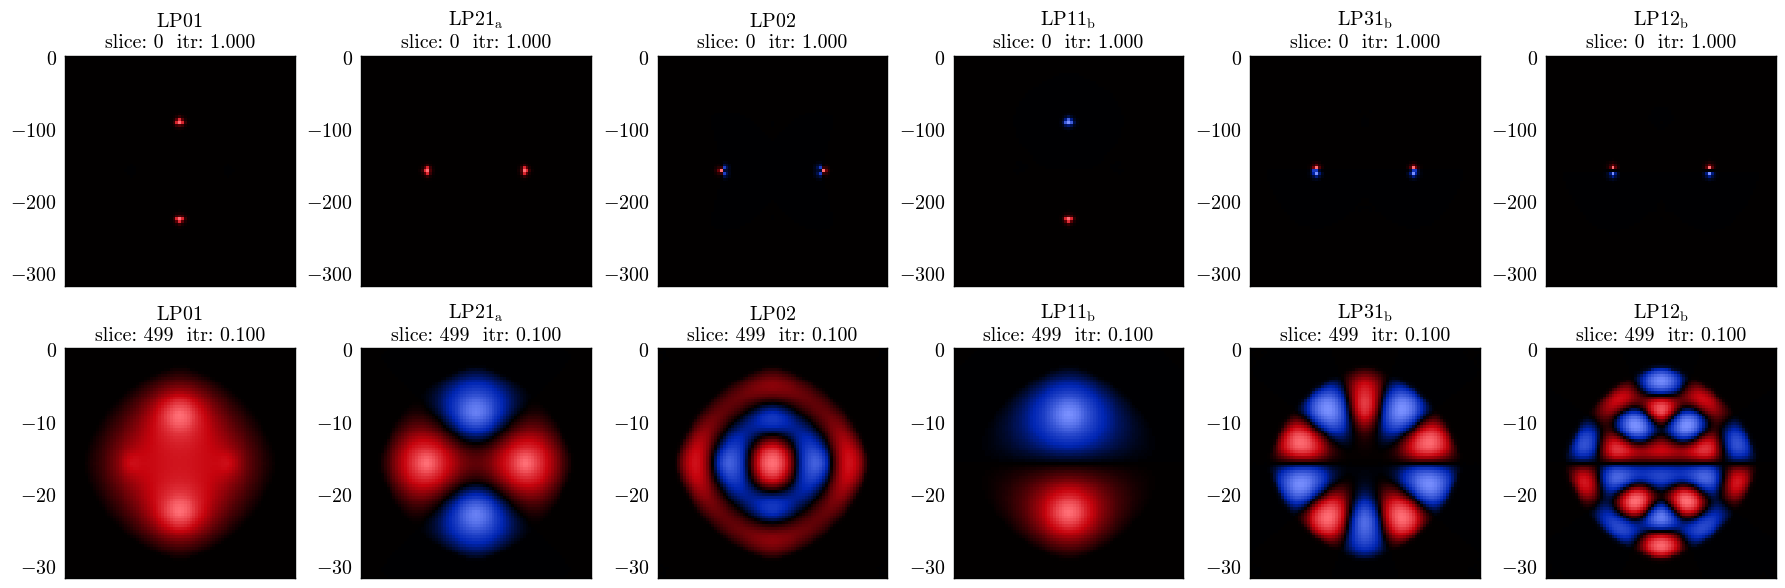

In [13]:
_ = workflow.superset.plot(plot_type='field', itr_list=[1.0, 0.1])

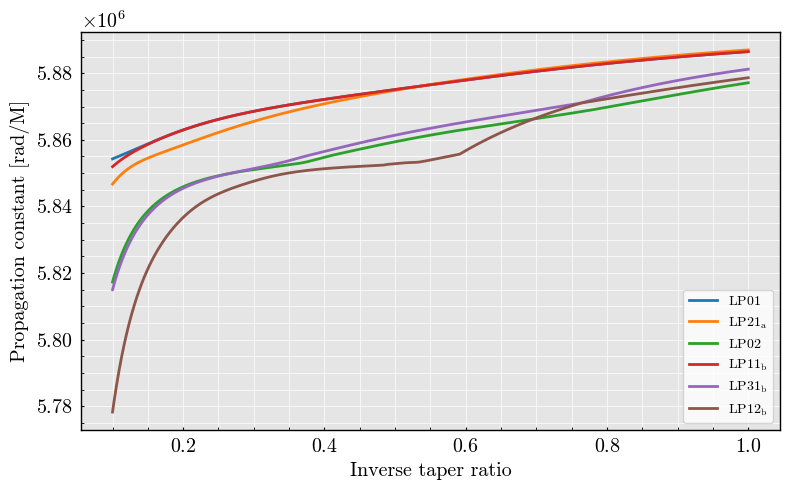

In [14]:
_ = workflow.superset.plot(plot_type='beta')

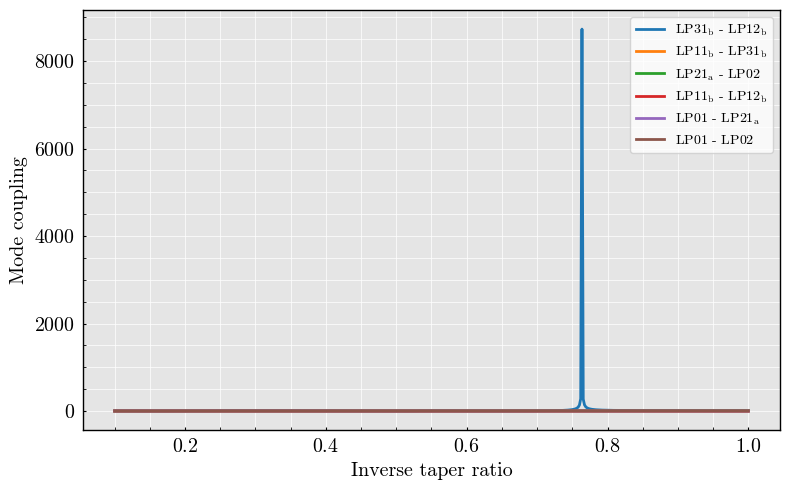

In [15]:
_ = workflow.superset.plot(plot_type='normalized_coupling')

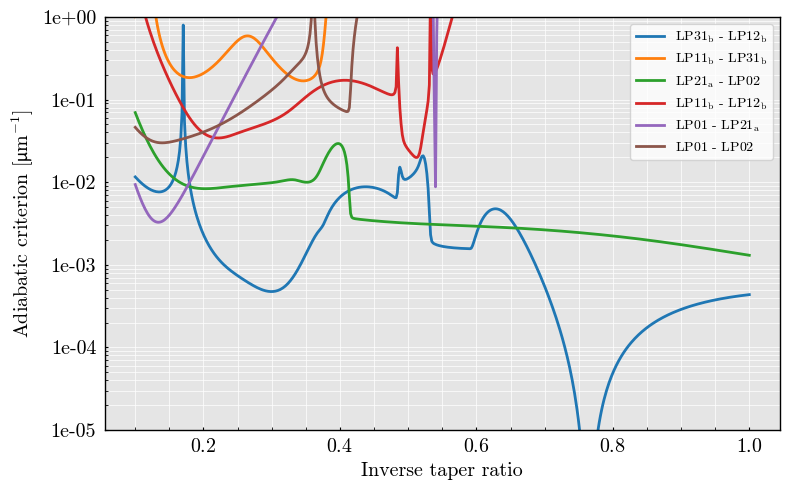

In [16]:
_ = workflow.superset.plot(plot_type='adiabatic')